In [1]:
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Getting the data

Recover dataset built in previous datasets

In [2]:
accidents_df = pd.read_csv('../data/processed/accidents.csv', sep=';')

/home/mayra/workspace/corvusenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,7,17,23,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
accidents_df.head()

,Unnamed: 0,ano,br,causa_acidente,classificacao_acidente,condicao_metereologica,data_inversa,delegacia,dia_semana,fase_dia,...,sentido_via,tipo_acidente,tipo_pista,tracado_via,uf,uop,uso_solo,veiculos,data,infracoes
0,0,2007,101.0,Falta de atenção,Sem Vítimas,Ceu Claro,01/01/2007,NaN,Segunda,Plena noite,...,Crescente,Saída de Pista,Simples,Cruzamento,RN,NaN,Rural,1,2007-01-01,0
1,1,2007,304.0,Outras,Com Vítimas Feridas,Ceu Claro,01/01/2007,NaN,Segunda,Plena noite,...,Crescente,Colisão com objeto móvel,Simples,Reta,RN,NaN,Rural,1,2007-01-01,0
2,2,2007,101.0,Não guardar distância de segurança,Sem Vítimas,Ceu Claro,01/01/2007,NaN,Segunda,Anoitecer,...,Crescente,Colisão traseira,Dupla,Reta,RN,NaN,Urbano,1,2007-01-01,0
3,3,2007,101.0,Ingestão de álcool,Sem Vítimas,Ceu Claro,01/01/2007,NaN,Segunda,Pleno dia,...,Decrescente,Colisão traseira,Dupla,Reta,RN,NaN,Rural,3,2007-01-01,0
4,4,2007,304.0,Não guardar distância de segurança,Sem Vítimas,Ceu Claro,01/01/2007,NaN,Segunda,Pleno dia,...,Crescente,Colisão traseira,Simples,Reta,RN,NaN,Urbano,2,2007-01-01,0


In [4]:
accidents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35804 entries, 0 to 35803
Data columns (total 34 columns):
Unnamed: 0                35804 non-null int64
ano                       35804 non-null object
br                        35804 non-null float64
causa_acidente            35804 non-null object
classificacao_acidente    35804 non-null object
condicao_metereologica    35804 non-null object
data_inversa              35804 non-null object
delegacia                 2865 non-null object
dia_semana                35804 non-null object
fase_dia                  35804 non-null object
feridos                   35804 non-null int64
feridos_graves            35804 non-null int64
feridos_leves             35804 non-null int64
horario                   35804 non-null object
id                        35804 non-null float64
ignorados                 35804 non-null int64
ilesos                    35804 non-null int64
km                        35804 non-null object
latitude                  2865 n

First, we remove the columns with missing data

In [5]:
accidents_cleaned_df = accidents_df.drop(labels=['latitude', 'longitude', 'uop', 'regional', 'delegacia'],
                                        axis='columns')

In [6]:
accidents_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35804 entries, 0 to 35803
Data columns (total 29 columns):
Unnamed: 0                35804 non-null int64
ano                       35804 non-null object
br                        35804 non-null float64
causa_acidente            35804 non-null object
classificacao_acidente    35804 non-null object
condicao_metereologica    35804 non-null object
data_inversa              35804 non-null object
dia_semana                35804 non-null object
fase_dia                  35804 non-null object
feridos                   35804 non-null int64
feridos_graves            35804 non-null int64
feridos_leves             35804 non-null int64
horario                   35804 non-null object
id                        35804 non-null float64
ignorados                 35804 non-null int64
ilesos                    35804 non-null int64
km                        35804 non-null object
mortos                    35804 non-null int64
municipio                 35804 

## A fancier pre-processing

The last step before training the model is encoding the categorical data.

In [7]:
categorical = ['causa_acidente', 'fase_dia','tracado_via',
               'condicao_metereologica', 'dia_semana', 'uso_solo',
               'sentido_via', 'tipo_acidente', 'tipo_pista']
# numeric
other = list(set(accidents_cleaned_df.columns) - set(categorical))

We need to normalize the categorical data first.

In [8]:
for category in categorical + ['classificacao_acidente']:
    accidents_cleaned_df[category] = accidents_cleaned_df[category].str.strip()
    accidents_cleaned_df[category] = accidents_cleaned_df[category].str.lower()
    
accidents_cleaned_df['dia_semana'] = accidents_cleaned_df['dia_semana'].str.split('-').str.get(0)

In [9]:
enc = OneHotEncoder()
data = enc.fit_transform(accidents_cleaned_df[categorical])

# transform to df agagin
data_df = pd.DataFrame(data.toarray())
data_df.columns = [cat for arr in enc.categories_ for cat in arr]
# encode labels
label_enc = LabelEncoder()
labels = label_enc.fit_transform(accidents_cleaned_df['classificacao_acidente'])
print(labels)


[3 1 3 ... 1 1 1]


In [10]:
# add another data
data_df = accidents_cleaned_df[other].join(data_df).drop(labels=['missing_value', 'classificacao_acidente'], axis='columns', 
                                                                     errors='ignore')
data_df['classificacao_acidente'] = labels

In [11]:
data_df.head()

,km,ano,ilesos,data,feridos_leves,feridos_graves,municipio,mortos,pessoas,Unnamed: 0,...,incêndio,queda de motocicleta / bicicleta / veículo,queda de ocupante de veículo,saída de leito carroçável,saída de pista,tombamento,dupla,múltipla,simples,classificacao_acidente
0,75,2007,1,2007-01-01,0,0,EXTREMOZ,0,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3
1,284.2,2007,0,2007-01-01,0,1,MACAIBA,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,82.1,2007,2,2007-01-01,0,0,SAO GONCALO DO AMARANTE,0,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3
3,109.3,2007,3,2007-01-01,0,0,PARNAMIRIM,0,3,3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3
4,33.8,2007,2,2007-01-01,0,0,MOSSORO,0,2,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3


In [12]:
# Remove irrelevant data
data_df.drop(labels=['id', 'horario', 'data_inversa', 'municipio', 'uf', 'Unnamed: 0', "(null)"], 
             axis='columns', inplace=True)

In [13]:
list(data_df.columns)

['km',
 'ano',
 'ilesos',
 'data',
 'feridos_leves',
 'feridos_graves',
 'mortos',
 'pessoas',
 'veiculos',
 'infracoes',
 'ignorados',
 'feridos',
 'br',
 'agressão externa',
 'animais na pista',
 'avarias e/ou desgaste excessivo no pneu',
 'carga excessiva e/ou mal acondicionada',
 'condutor dormindo',
 'defeito mecânico em veículo',
 'defeito mecânico no veículo',
 'defeito na via',
 'deficiência ou não acionamento do sistema de iluminação/sinalização do veículo',
 'desobediência à sinalização',
 'desobediência às normas de trânsito pelo condutor',
 'desobediência às normas de trânsito pelo pedestre',
 'dormindo',
 'falta de atenção',
 'falta de atenção do pedestre',
 'falta de atenção à condução',
 'fenômenos da natureza',
 'ingestão de substâncias psicoativas',
 'ingestão de álcool',
 'ingestão de álcool e/ou substâncias psicoativas pelo pedestre',
 'mal súbito',
 'não guardar distância de segurança',
 'objeto estático sobre o leito carroçável',
 'outras',
 'pista escorregadia',
 

# Final cleaning
Using correlation to remove some columns

In [14]:
# Exclude targets
columns = data_df.columns.str.startswith("class")

# Compute the correlation matrix
corr = data_df.iloc[:,np.logical_not(columns)].corr()

for index, row in corr.iterrows():
    for val in row :
        if (val > 0.7) or (val < -0.7):
            indx = row[ row == val].index[0]
            if index != indx:
                print('{}, {} ({})'.format(index, indx, val))

feridos_leves, feridos (0.8339890937409264)
feridos, feridos_leves (0.8339890937409264)
animais na pista, atropelamento de animal (0.8812513845146636)
falta de atenção do pedestre, atropelamento de pedestre (0.7566609073235597)
plena noite, pleno dia (-0.8168794416988738)
pleno dia, plena noite (-0.8168794416988738)
rural, urbano (-0.826946240732112)
urbano, rural (-0.826946240732112)
crescente, decrescente (-1.0)
decrescente, crescente (-1.0)
atropelamento de animal, animais na pista (0.8812513845146636)
atropelamento de pedestre, falta de atenção do pedestre (0.7566609073235597)
dupla, simples (-0.8113896783062018)
simples, dupla (-0.8113896783062018)


### Correlations:
| Column 1        | Column2           | Corr  |
| ------------- |:-------------:| -----:|
|animais na pista| atropelamento de animal |0.8812513845146636|
|feridos| feridos_leves |0.8339890937409264|
|falta de atenção do pedestre| atropelamento de pedestre |0.7566609073235597|
|dupla| simples |-0.8113896783062018|
|plena noite| pleno dia |-0.8168794416988738|
|rural| urbano |-0.826946240732112|
|crescente| decrescente |-1.0|

In [15]:
# Remove redundant data
data_df.drop(labels=['animais na pista', 'feridos', 'dupla', 'plena noite',
                     'rural', 'crescente'], axis='columns', inplace=True)

In [16]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35804 entries, 0 to 35803
Columns: 101 entries, km to classificacao_acidente
dtypes: float64(89), int64(9), object(3)
memory usage: 27.6+ MB


In [17]:
data_df.to_csv('../data/processed/accidents_categorized.csv', sep=';')

## Verify balance

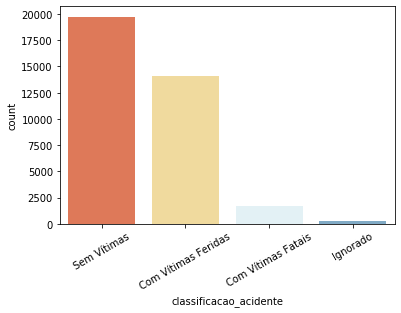

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.countplot(x='classificacao_acidente', data=accidents_df, palette='RdYlBu')
plt.setp(g.get_xticklabels(), rotation=30)

plt.show()